# Hands-on 03: Tabular data and NNs: Classifying particle jets

## Follow along

In [2]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import numpy as np
import tensorflow as tf

%matplotlib inline
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

### Fetch the jet tagging dataset from Open ML

In [3]:
data = fetch_openml("hls4ml_lhc_jets_hlf", parser="auto")
X, y = data["data"], data["target"]

### Lets see what the jet variables look like

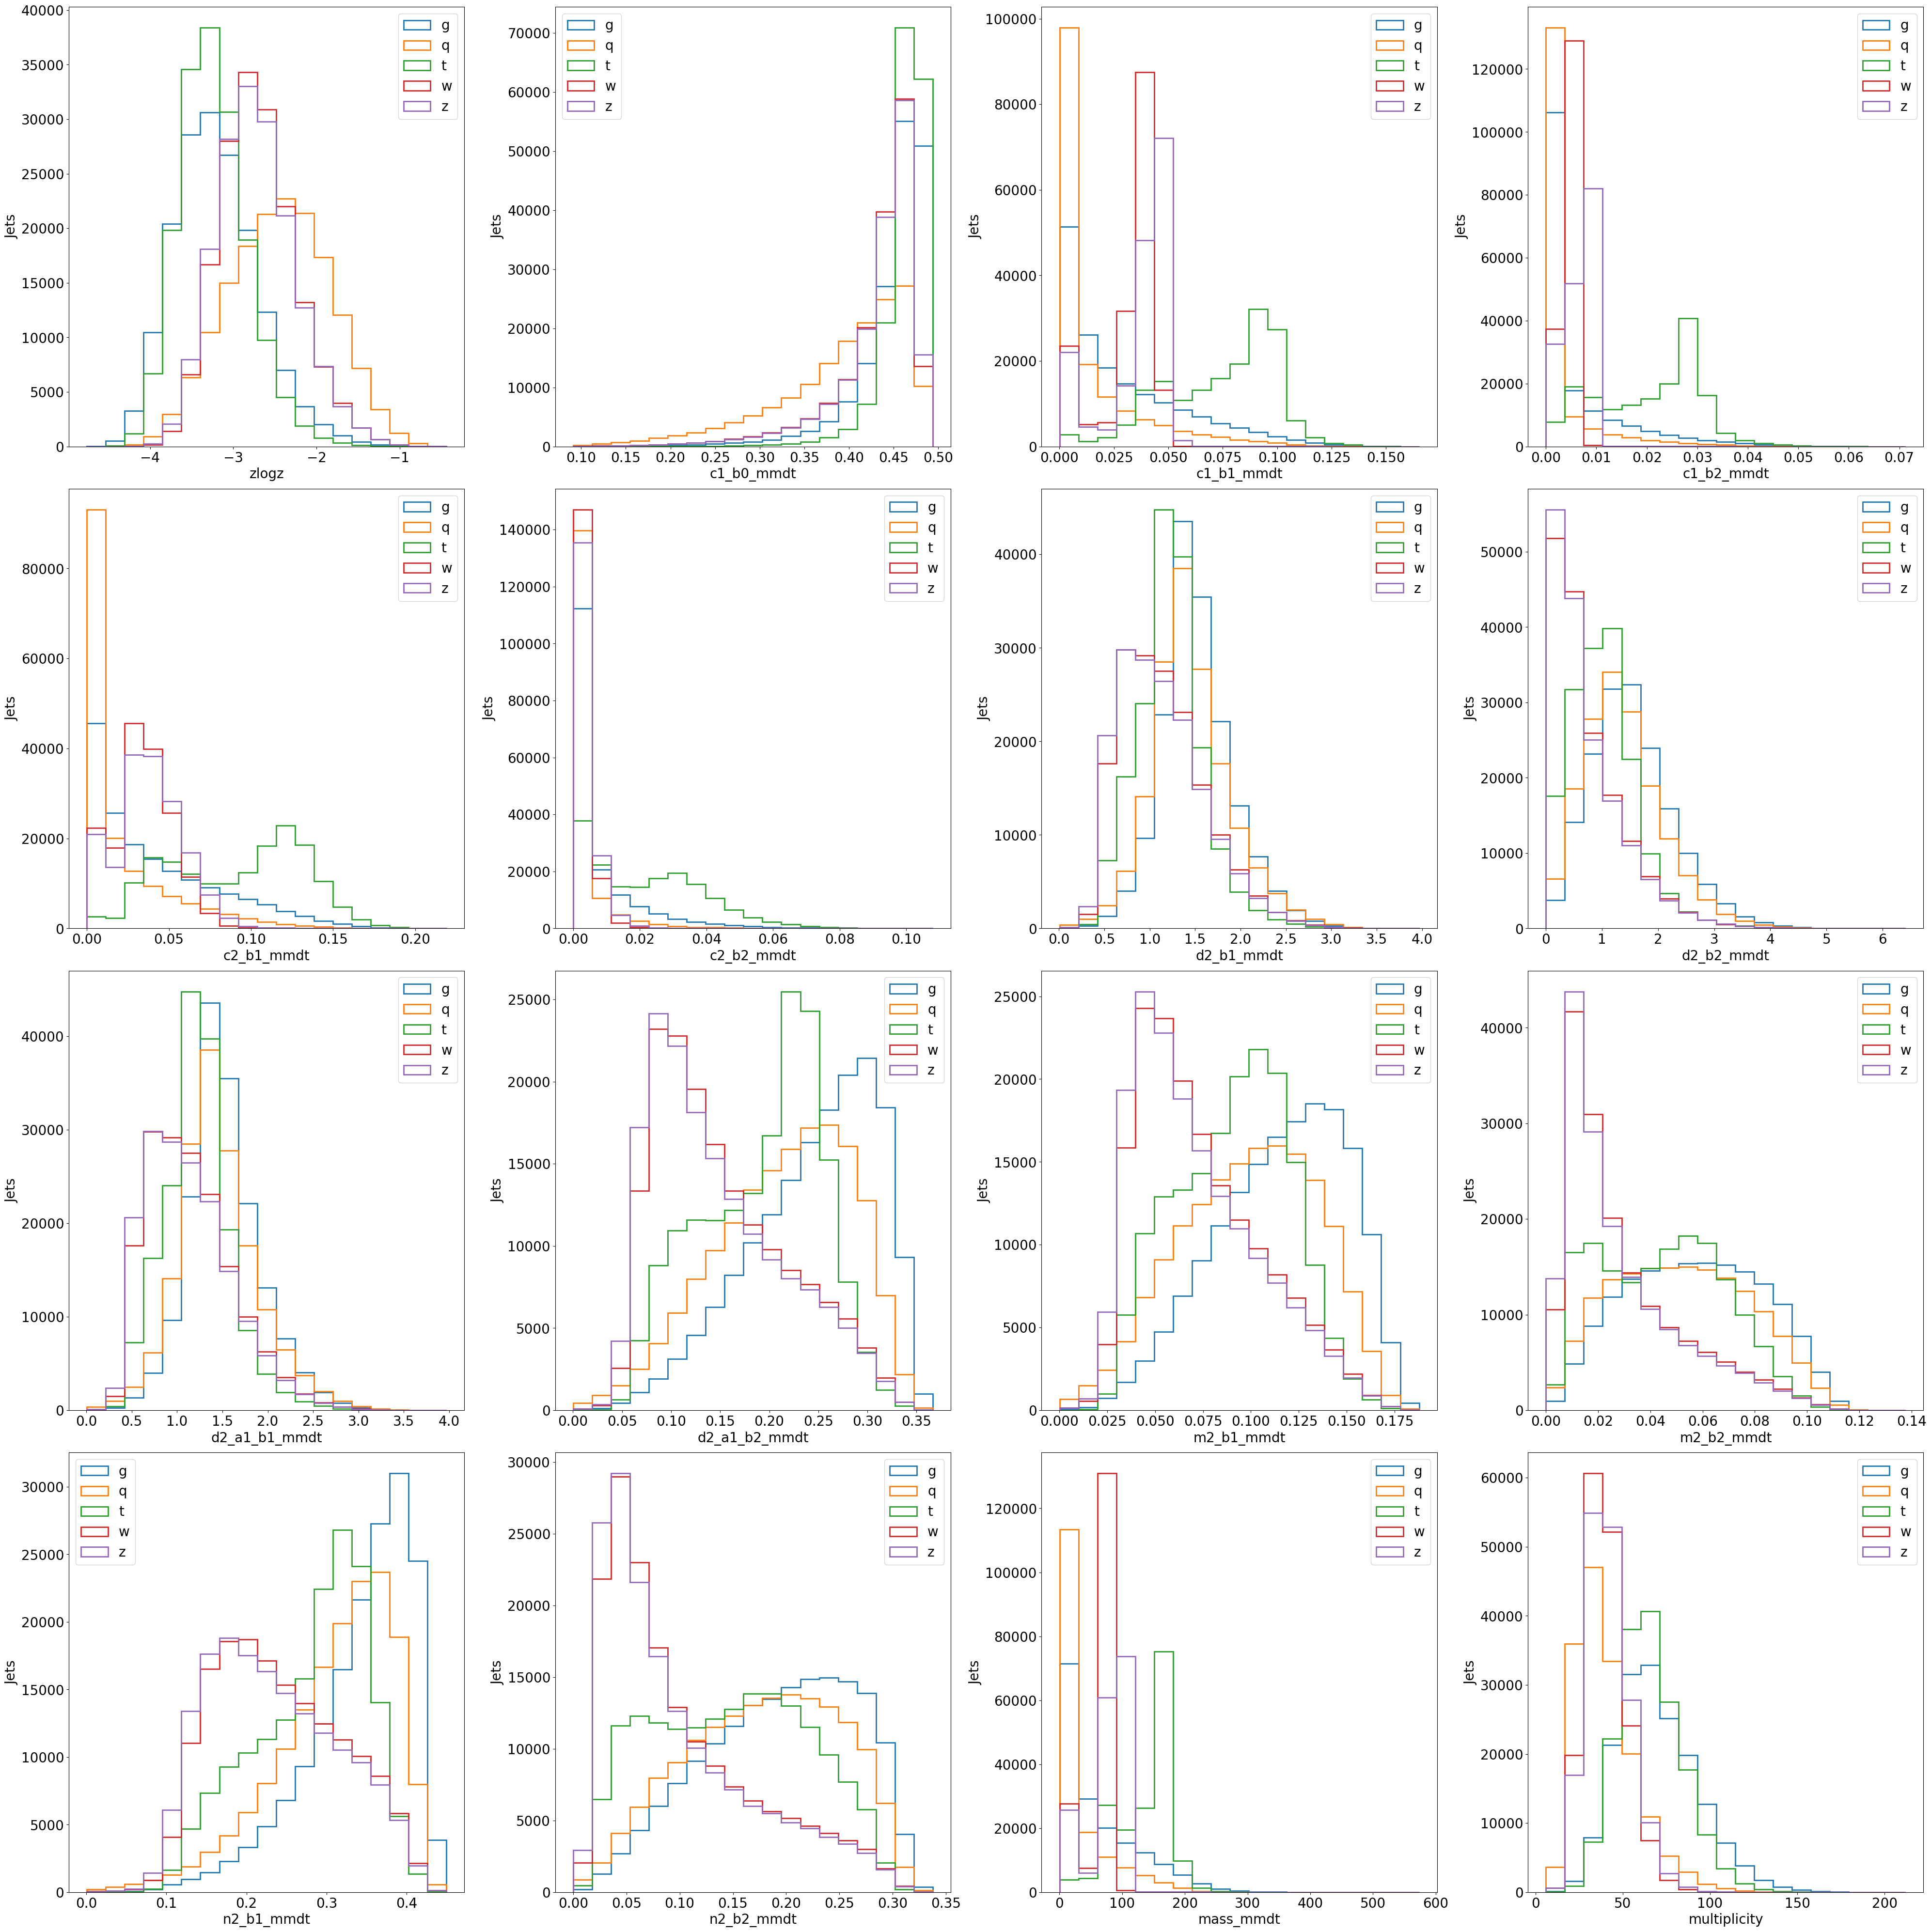

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 4, figsize=(40, 40))

for ix, ax in enumerate(axs.reshape(-1)):
    feat = data["feature_names"][ix]
    bins = np.linspace(np.min(X[:][feat]), np.max(X[:][feat]), 20)
    for c in y.dtype.categories:
        ax.hist(X[y == c][feat], bins=bins, histtype="step", label=c, lw=2)
    ax.set_xlabel(feat, fontsize=20)
    ax.set_ylabel("Jets", fontsize=20)
    ax.tick_params(axis="both", which="major", labelsize=20)
    ax.legend(fontsize=20, loc="best")
plt.tight_layout()
plt.show()

In [5]:
le = LabelEncoder()
y_onehot = le.fit_transform(y)
y_onehot = to_categorical(y_onehot, 5)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)
print(y[:5])
print(y_onehot[:5])

0    g
1    w
2    t
3    z
4    w
Name: class, dtype: category
Categories (5, str): ['g', 'q', 't', 'w', 'z']
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


### Now construct a simple neural network
We'll use 3 hidden layers with 64, then 32, then 32 neurons. Each layer will use `relu` activation.
Add an output layer with 5 neurons (one for each class), then finish with Softmax activation.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1

In [7]:
model = Sequential(name="sequential1")
model.add(Input(shape=(16,)))
model.add(Dense(64, name="fc1"))
model.add(Activation(activation="relu", name="relu1"))
model.add(Dense(32, name="fc2"))
model.add(Activation(activation="relu", name="relu2"))
model.add(Dense(32, name="fc3"))
model.add(Activation(activation="relu", name="relu3"))
model.add(Dense(5, name="fc4"))
model.add(Activation(activation="softmax", name="softmax"))
model.summary()

Model: "sequential1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fc1 (Dense)                     │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (Activation)              │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2 (Activation)              │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc3 (Dense)                     │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3 (Activation)              │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc4 (Dense)                     │ (None, 5)              │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Activation)            │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,389 (17.14 KB)

 Trainable params: 4,389 (17.14 KB)

 Non-trainable params: 0 (0.00 B)

### Train the model
We'll use SGD optimizer with categorical crossentropy loss.
The model isn't very complex, so this should just take a few minutes even on the CPU.

In [8]:
model.compile(optimizer="sgd", loss=["categorical_crossentropy"], metrics=["accuracy"])
history = model.fit(X_train_val, y_train_val, batch_size=1024, epochs=50, validation_split=0.25, shuffle=True, verbose=0)

In [9]:
def distribution_weights(model):
    for layer in model.layers:
        w = layer.get_weights()
        if w:
            arr = w[0]
            print(layer.name, "min: ", np.min(arr), "max: ", np.max(arr), "mean: ", np.mean(arr), "std: ", np.std(arr))

In [10]:
distribution_weights(model)

fc1 min:  -1.0470183 max:  1.1595285 mean:  -0.0075801085 std:  0.195803
fc2 min:  -0.33345583 max:  0.2917793 mean:  -0.0077934638 std:  0.14296396
fc3 min:  -0.50432956 max:  0.4542084 mean:  -0.0017521027 std:  0.17972311
fc4 min:  -1.1881707 max:  0.9692119 mean:  0.017367262 std:  0.36988643


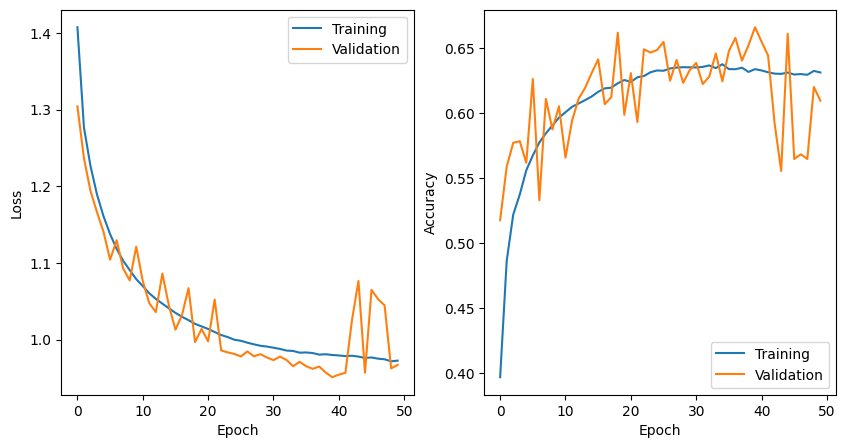

In [11]:
from plotting import plot_model_history

plot_model_history(history)

### Check performance
Check the accuracy and make a ROC curve

In [12]:
from plotting import make_roc, plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

y_keras = model.predict(X_test, batch_size=1024, verbose=0)
print(f"Accuracy: {accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))}")

Accuracy: 0.6082349397590362


<Figure size 500x500 with 0 Axes>

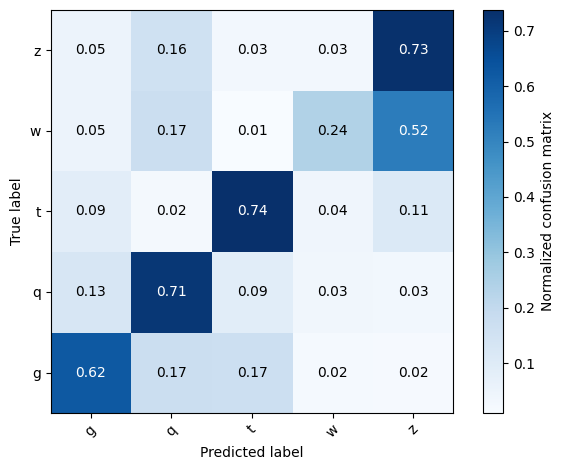

In [13]:
plt.figure(figsize=(5, 5))
plot_confusion_matrix(y_test, y_keras, classes=le.classes_, normalize=True)

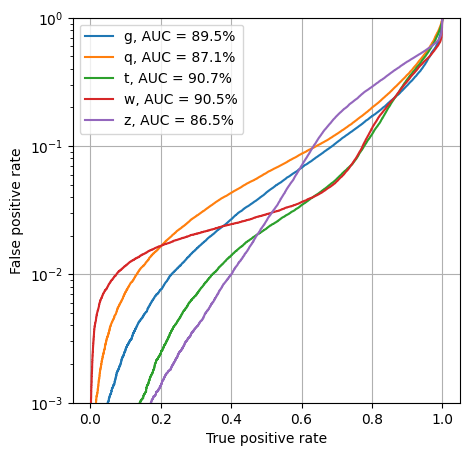

In [14]:
plt.figure(figsize=(5, 5))
make_roc(y_test, y_keras, le.classes_)

## Exercises

In [15]:
def run_model(name, 
              X_training_data, 
              y_training_data, 
              X_test_data, 
              y_test_data, 
              optimizer="sgd", 
              scaled=False, 
              regularization=False, 
              modelSummary=False):

    if scaled:
        scaler = StandardScaler()
        X_training_data = scaler.fit_transform(X_training_data)
        X_test_data = scaler.transform(X_test_data)

    model = Sequential(name=f"sequential1_{name}")
    model.add(Input(shape=(16,)))
    
    if regularization:
        model.add(Dense(64, name="fc1", kernel_regularizer=l1(0.01)))
    else:
        model.add(Dense(64, name="fc1"))
    model.add(Activation(activation="relu", name="relu1"))
    model.add(Dense(32, name="fc2"))
    model.add(Activation(activation="relu", name="relu2"))
    model.add(Dense(32, name="fc3"))
    model.add(Activation(activation="relu", name="relu3"))
    model.add(Dense(5, name="fc4"))
    model.add(Activation(activation="softmax", name="softmax"))

    if modelSummary:
        model.summary()

    model.compile(optimizer=optimizer, loss=["categorical_crossentropy"], metrics=["accuracy"])
    history = model.fit(X_training_data, y_training_data, batch_size=1024, epochs=50, validation_split=0.25, shuffle=True, verbose=0)

    plot_model_history(history)

    y_keras = model.predict(X_test_data, batch_size=1024, verbose=0)
    print(f"Accuracy: {accuracy_score(np.argmax(y_test_data, axis=1), np.argmax(y_keras, axis=1))}")

    distribution_weights(model)

    plt.figure(figsize=(5, 5))
    plot_confusion_matrix(y_test_data, y_keras, classes=le.classes_, normalize=True)

    plt.figure(figsize=(5, 5))
    make_roc(y_test_data, y_keras, le.classes_)

    return model

1. Apply a standard scaler to the inputs. How does the performance of the model change?

```python
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)
```

Accuracy: 0.7492048192771085
fc1 min:  -0.6972411 max:  1.4959888 mean:  -0.0047975243 std:  0.19467126
fc2 min:  -0.71080106 max:  0.47231993 mean:  0.0060272356 std:  0.16698979
fc3 min:  -0.5945778 max:  0.6200948 mean:  -0.0045326417 std:  0.21238191
fc4 min:  -1.0746753 max:  1.0037723 mean:  -0.014541777 std:  0.38414928


<Sequential name=sequential1_scaled, built=True>

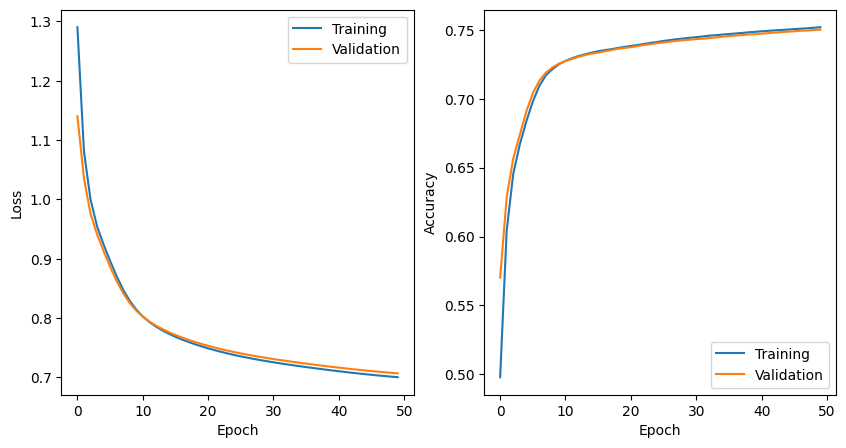

<Figure size 500x500 with 0 Axes>

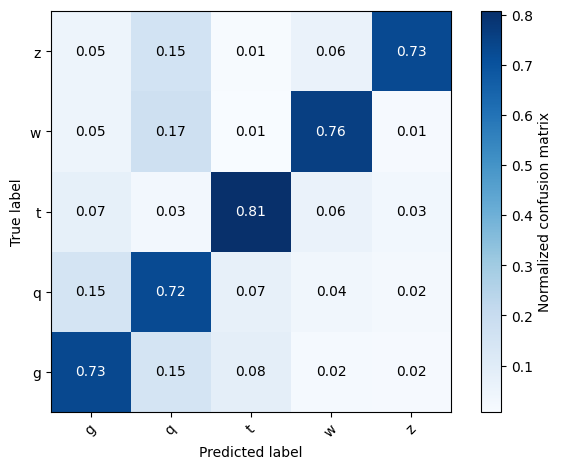

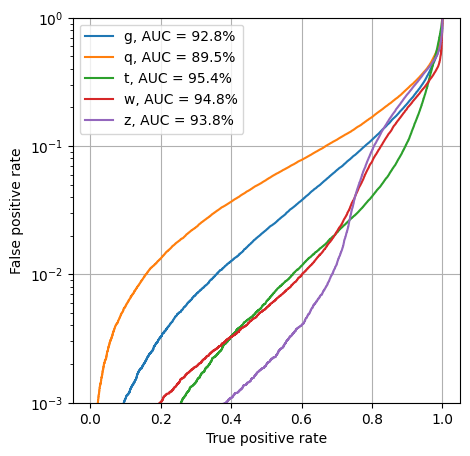

In [16]:
run_model("scaled", X_train_val, y_train_val, X_test, y_test, scaled=True)

With the scaling, the loss and accuracy curves are very smooooth. Also the accuracy went way up, overall very good effect.

2. Apply L1 regularization. How does the performance of the model change? How do the distribution of the weight values change?

```python
model.add(Dense(64, input_shape=(16,), name="fc1", kernel_regularizer=l1(0.01)))
```

Accuracy: 0.5648795180722892
fc1 min:  -0.068717696 max:  0.23690452 mean:  0.0007591712 std:  0.012971567
fc2 min:  -0.37616462 max:  0.3731854 mean:  -0.0010794414 std:  0.1439574
fc3 min:  -0.5453241 max:  0.50437176 mean:  0.007048251 std:  0.18619554
fc4 min:  -1.1301262 max:  1.2366422 mean:  0.013635397 std:  0.36573339


<Sequential name=sequential1_L1, built=True>

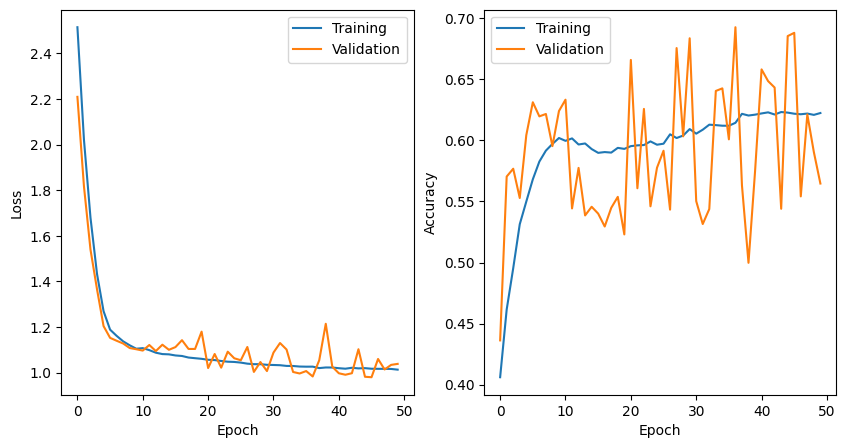

<Figure size 500x500 with 0 Axes>

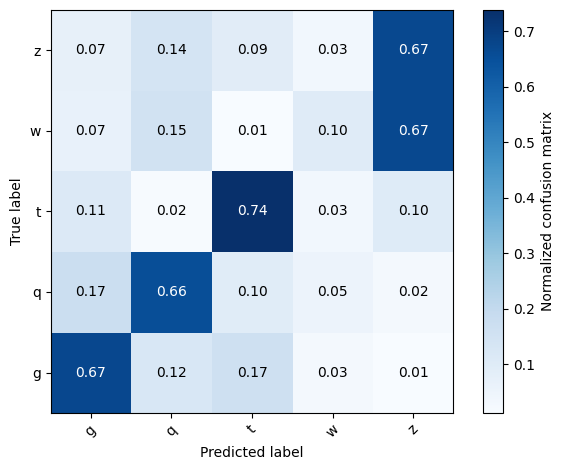

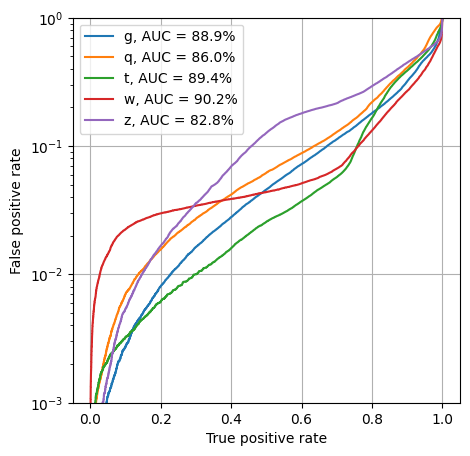

In [ ]:
run_model("L1", X_train_val, y_train_val, X_test, y_test, regularization=True)

3. How do the loss curves change if we use a smaller learning rate (say `1e-5`) or a larger one (say `0.1`)?

Accuracy: 0.3423975903614458
fc1 min:  -0.27380824 max:  0.2763283 mean:  0.0046199765 std:  0.15473199
fc2 min:  -0.25294265 max:  0.25226074 mean:  -0.00514176 std:  0.14175405
fc3 min:  -0.30614704 max:  0.3119812 mean:  -0.0036122734 std:  0.18058378
fc4 min:  -0.39139897 max:  0.39898956 mean:  -0.0038495972 std:  0.23330776
Accuracy: 0.2016566265060241
fc1 min:  -97525.484 max:  3356.983 mean:  -337.14032 std:  4304.066
fc2 min:  -3.7962168e+06 max:  216790.89 mean:  -3126.5369 std:  92918.516
fc3 min:  -681894.4 max:  515.36865 mean:  -2621.2642 std:  28438.91
fc4 min:  -6748.86 max:  2229.5803 mean:  0.00068511965 std:  815.6741


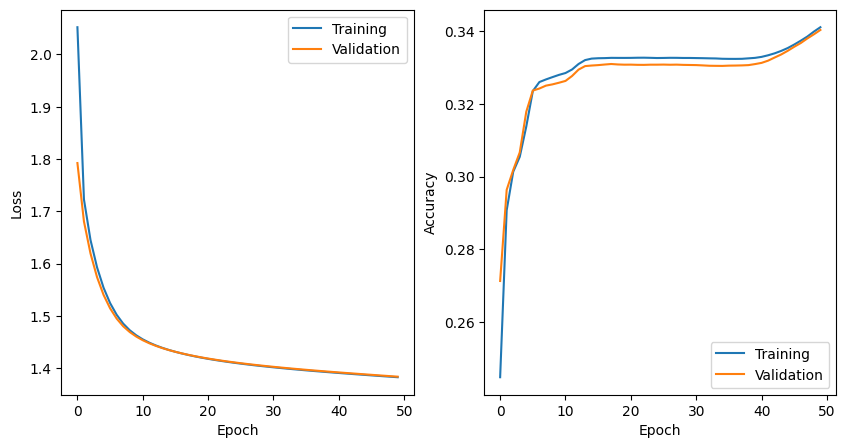

<Figure size 500x500 with 0 Axes>

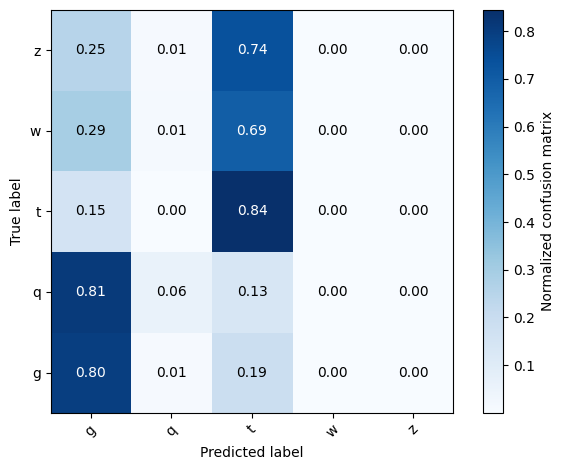

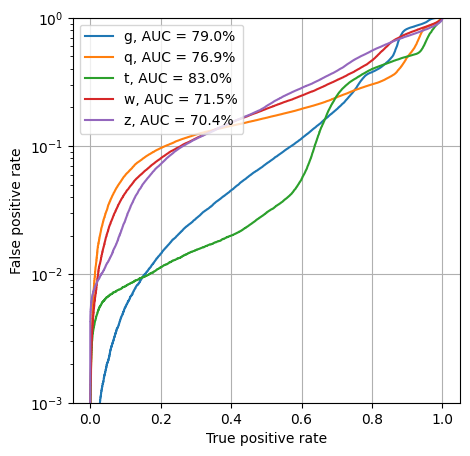

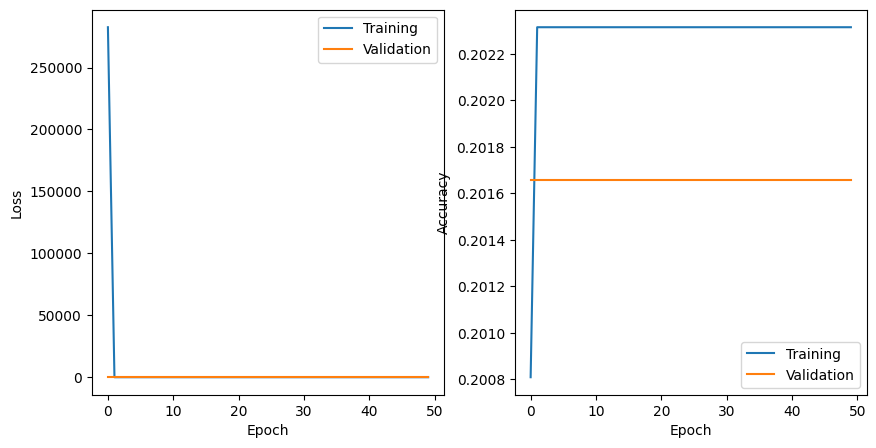

<Figure size 500x500 with 0 Axes>

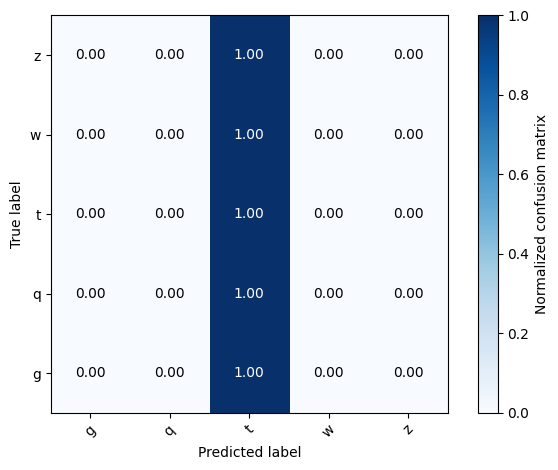

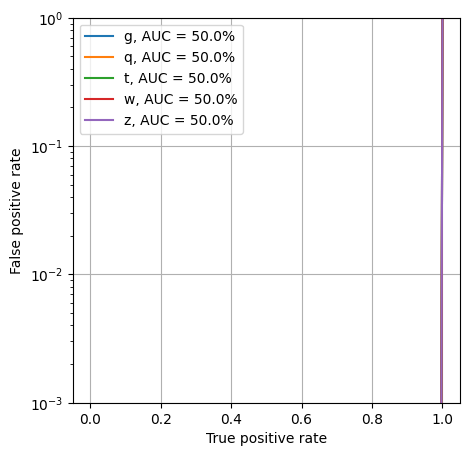

In [ ]:
from tensorflow.keras.optimizers import SGD

learning_rates = [1e-5, 0.1]

for lr in learning_rates:
    model = run_model(f"lr_{lr}", X_train_val, y_train_val, X_test, y_test, optimizer=SGD(learning_rate=lr))

Both are quite shit. 1e-5 won't get anywhere, and with 0.1 the weights are exploding making t the answer to everything

4. How does the loss curve change and the performance of the model change if we use Adam as the optimizer instead of SGD?

Accuracy: 0.5349939759036144
fc1 min:  -0.9018445 max:  1.1101032 mean:  -0.012129007 std:  0.18807948
fc2 min:  -0.35119617 max:  0.53683394 mean:  -0.006469223 std:  0.14495628
fc3 min:  -0.54729956 max:  0.47858587 mean:  -0.004440236 std:  0.18243611
fc4 min:  -1.7156276 max:  1.251062 mean:  -0.0043031434 std:  0.37132877


<Sequential name=sequential1_sgd, built=True>

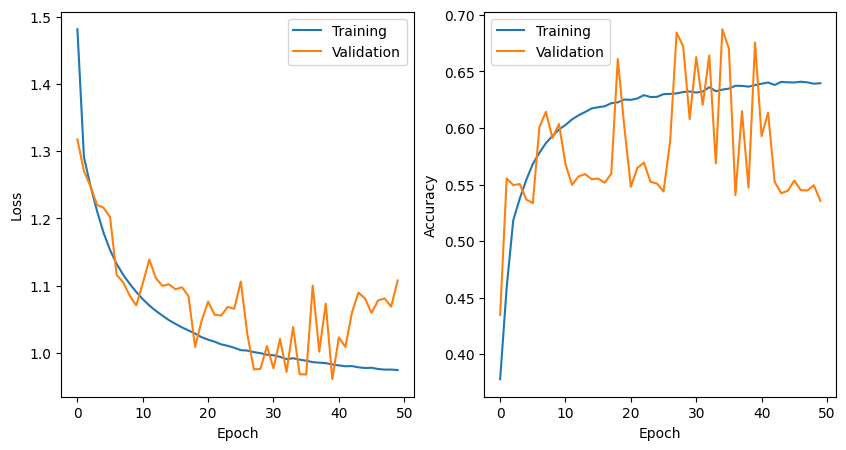

<Figure size 500x500 with 0 Axes>

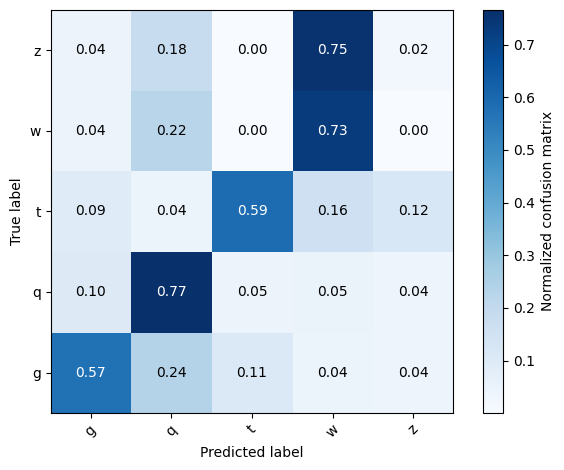

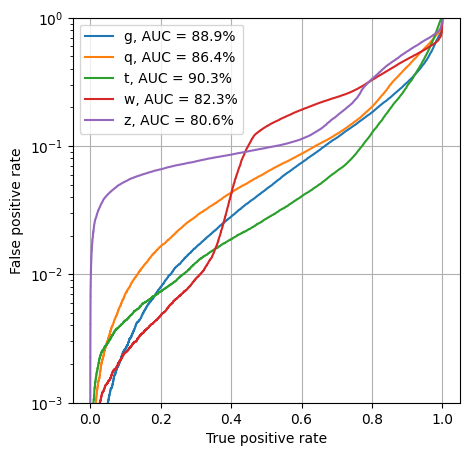

In [ ]:
run_model(f"sgd", X_train_val, y_train_val, X_test, y_test)

Accuracy: 0.7433493975903614
fc1 min:  -6.576317 max:  6.3866954 mean:  -0.049999982 std:  1.335469
fc2 min:  -1.647329 max:  1.1457243 mean:  -0.004924349 std:  0.19020441
fc3 min:  -2.8531551 max:  1.6692454 mean:  -0.006563271 std:  0.28431255
fc4 min:  -1.6900365 max:  1.8332944 mean:  0.0103285415 std:  0.49108788


<Sequential name=sequential1_adam, built=True>

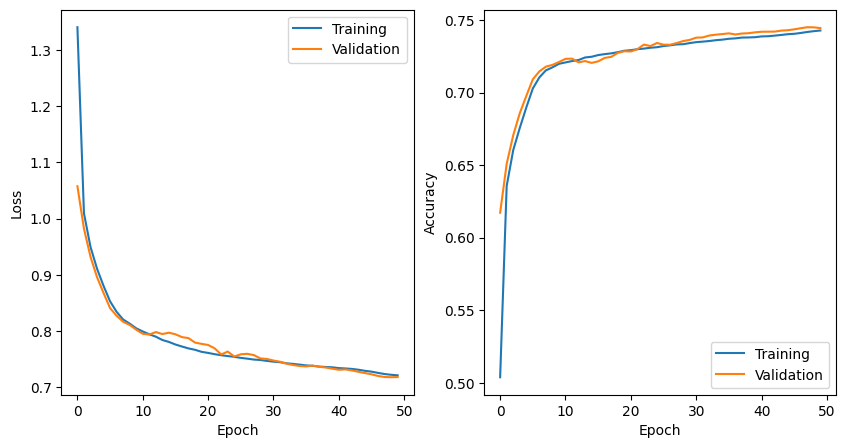

<Figure size 500x500 with 0 Axes>

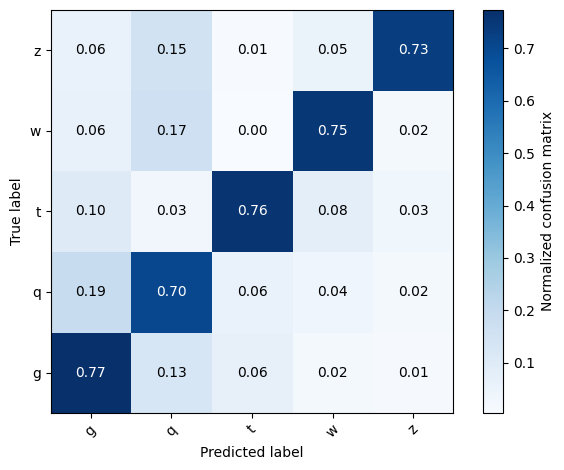

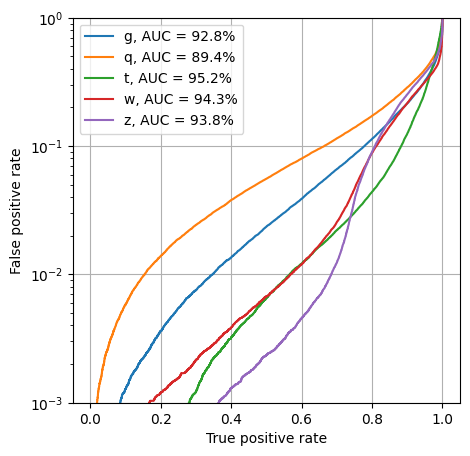

In [ ]:
run_model(f"adam", X_train_val, y_train_val, X_test, y_test, optimizer="adam")

Very smooth, this is because Adam can change the learning rate based on the gradient. So we dont get the jaggedy curve like before and it reaches a pretty nice accuracy.